# Beware the Propensity Score: It's a Collider

## Motivation
Propensity score matching (PSM) has become a [popular][1] workhorse in observational causal inference ever since its introduction by [Rosenbaum and Rubin][2] in 1983.  However, a recent manuscript by [King and Nielsen][3] argues that PSM increases "imbalance, inefficiency, model dependence, and bias". In their view, propensity scores should not be used for matching.  This is a strong, important, and potentially very troubling claim.

My purpose is to reframe their claims in the modern language of directed acyclic graphs. Specifically, I show how the propensity score is a collider, and how PSM tries to recreate a complete randomized experiment stratified along _Isopropenity Sets_ (defined below). This can indeed result in small sample bias, inefficiency, and model dependence.  However, the extent of the problem will likely depend on the specific PSM algorithm used, of which there are [many][4].

My hope is that a graphical approach will help some readers better understand the structural root causes of the problem. It certainly helped me!

[1]:https://books.google.com/ngrams/graph?content=propensity+score%2Ccausal+inference%2Cdirected+acyclic+graphs&case_insensitive=on&year_start=1980&year_end=2008&corpus=15&smoothing=3&share=&direct_url=t4%3B%2Cpropensity%20score%3B%2Cc0%3B%2Cs0%3B%3Bpropensity%20score%3B%2Cc0%3B%3BPropensity%20Score%3B%2Cc0%3B%3BPropensity%20score%3B%2Cc0%3B.t4%3B%2Ccausal%20inference%3B%2Cc0%3B%2Cs0%3B%3Bcausal%20inference%3B%2Cc0%3B%3BCausal%20Inference%3B%2Cc0%3B%3BCausal%20inference%3B%2Cc0%3B%3BCAUSAL%20INFERENCE%3B%2Cc0%3B.t4%3B%2Cdirected%20acyclic%20graphs%3B%2Cc0%3B%2Cs0%3B%3Bdirected%20acyclic%20graphs%3B%2Cc0%3B%3BDirected%20Acyclic%20Graphs%3B%2Cc0%3B%3BDirected%20acyclic%20graphs%3B%2Cc0
[2]:https://doi.org/10.1093/biomet/70.1.41
[3]:https://gking.harvard.edu/publications/why-propensity-scores-should-not-be-used-formatching
[4]:https://doi.org/10.1002/sim.6004

In [1]:
# libraries
import numpy as np
import math as math
import scipy.stats as stats
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
import daft

# settings
# plt.rcParams['figure.figsize'] = 14, 8
# rc("font", family="serif", size=12)
# rc("text", usetex=True)
%matplotlib inline
plt.style.use('ggplot')

# functions
def sample_dgp1(N):
    """
    Returns a sample of data of size N from the true causal model or data generating process where Y is a function of X, e_y.
    """
    # Exogenous variables
    ex = stats.norm.rvs(size=N, loc=0, scale=1)
    ez = stats.norm.rvs(size=N, loc=0, scale=1)
    ey = stats.logistic.rvs(size=N, loc=0, scale=1)
    
    # Parameters
    # We will have all parameters in [-1 and 1], sample them in one batch
    params =  stats.uniform.rvs(size=7, loc=-1, scale=2)
    
    # Endogenous variables
    Z = params[0] + params[1]*ez
    X = params[2] + params[3]*ex
    Y = params[4] + params[5]*X + 0*Z + ey # Z zeroed out!
    
    # collect relevant variables in a DataFrame
    df = pd.DataFrame(data={'Y' : Y,
                            'X' : X,
                            #'Z' : Z,
                            'ey' : ey})
    
    # Add treatment indicator variable D
    df['D'] = np.where(df['Y']>0, 1, 0)
    
    return df


def sample_dgp2(N):
    """
    Returns a sample of data of size N from the true causal model or data generating process where Y is a function of X, Z, e_y.
    """
    # Exogenous variables
    ex = stats.norm.rvs(size=N, loc=0, scale=1)
    ez = stats.norm.rvs(size=N, loc=0, scale=1)
    ey = stats.logistic.rvs(size=N, loc=0, scale=math.pi**2/3)
    
    # Parameters
    # We will have all parameters in [-1 and 1], sample them in one batch
    params =  stats.uniform.rvs(size=7, loc=-1, scale=2)
    
    # Endogenous variables
    Z = params[0] + params[1]*ez
    X = params[2] + params[3]*ex
    Y = params[4] + params[5]*X + params[6]*Z + ey
    
    # collect relevant variables in a DataFrame
    df = pd.DataFrame(data={'Y' : Y,
                            'X' : X,
                            'Z' : Z,
                            'ey' : ey})
    
    # Add treatment indicator variable D
    df['D'] = np.where(df['Y']>0, 1, 0)
    
    return df

## Formal intuition
### The true causal model

Let's play God for a minute, and create our own structural causal model for treatment assignment. This model is true by definition.  Specifically:

$$
\begin{align}
    D_i &= \begin{cases}
               1 & \text{if $y_i > 0$} \\
               0 & \text{if $y_i \leq 0$}
           \end{cases}, \\
    Y_i &= W_i + \varepsilon_{y,i}, \\
    W_i &= \beta_0 + \beta_1 \cdot X_i + \beta_2 \cdot Z_i \\
    X_i &= \alpha_0 + \alpha_1 \cdot \varepsilon_{x,i}, \\
    Z_i &= \gamma_0 + \gamma_1 \cdot \varepsilon_{z,i}, \\
    \varepsilon_{y,i} &\sim \boldsymbol{\Lambda}(0,\pi^2/3),\\
    \varepsilon_{x,i} &\sim \mathcal{N}(0,1),\\
    \varepsilon_{z,i} &\sim \mathcal{N}(0,1),\\
    \varepsilon_{y,i} &\perp \varepsilon_{x,i} \perp \varepsilon_{z,i},
\end{align}
$$

whereby unit $i$ chooses treatment if and only if $D_i=1$ and chooses control otherwise.  Variables $X$ and $Z$ are confounders between the treatment and outcome (not shown for simplicity).  $Y$ is a latent variable.  Exogenous variables $\varepsilon_{j,i}, \ j \in \{Y, X, Z\}, \ i \in \{1, \dots, N\}$ capture all other exogenous causes of the endogenous variables $W, D, X, Y,$ and $Z$. We summarize these background causes using probability distributions, where $\boldsymbol{\Lambda}$ is the logistic distribution, and $\mathcal{N}$ the normal distribution. The exogenous variables are independently distributed. Variable $W_i$ is redundant, but it will help  with the exposition below.  

From this it follows that the *true* propensity score $Q_i$ is:

$$
\begin{align}
Q_i &= \text{Prob}(D_i = 1)\\ 
             &= \text{Prob}(\varepsilon_{Y,i} < w_i \ \mid x_i, z_i,\boldsymbol{\beta}),\\
                           &= \boldsymbol{\Lambda}(w_i), \\
                           &= \frac{e^{\mathbf{x_i'}\boldsymbol{\beta}}}{1 + e^{\mathbf{x_i'}\boldsymbol{\beta}}}.
\end{align}
$$

### The isopropesity set
An isopropensity set is a probability contour.  Namely, a set of points in covariate space where the true propensity score is constant. Let $q_i$ be a realization of $Q_i$: 

**Definition 1a (Isopropensity Set)**: For any propensity score $q_i$, its corresponding isopropesity set $\mathcal{I}_{q_i}$ is defined as the set $\{ \langle\mathbf{x_i}, d_i \rangle : \mathbb{P}(\mathbf{x_i};\boldsymbol{\beta}) = q_i, i \in \{1,\ldots,N\}\}$; where $\mathbb{P}()\!:\mathbf{x_i'}\boldsymbol{\beta} \rightarrow Q_i$ is a cumulative distribution function, like the logit, mapping the true propensity score $Q_i$ to its endogenous direct causes $\mathbf{X_i}$.

An alternative definition of the isopropensity set exploits the fact that a cumulative distribution function $\mathbb{P}()\!:\mathbf{x_i'}\boldsymbol{\beta} \rightarrow Q_i$ is injective.  This means that any $q_i$ can only be asociated with one value of $w_i=\mathbf{x_i'}\boldsymbol{\beta}$, and _vice versa_.  Denote the specific value $w_i$ associated with a unique propensity score $q_i$ as $w_i^{q_i}$.  

**Claim 1**: Conditioning on $Q_i=q_i$ is equivalent to conditioning on $W_i = w_i^{q_i}$.  
_Proof_: By contradiction.  Suppose any pair of observations for which $Q_i=q_i$ had different values of $W_i$, then there would exist $w_i \neq w_j$ s.t. $\boldsymbol{\Lambda}(w_i) = \boldsymbol{\Lambda}(w_j)$.  Function $\boldsymbol{\Lambda}()$ is injective $\rightarrow\leftarrow$.  

Hence, the alternative definition:

**Definition 1b (Isopropensity Set)**: For any propensity score $q_i$, its corresponding isopropesity set $\mathcal{I}_{q_i}$ is defined as the set $\{ \langle\mathbf{x_i}, d_i \rangle: 0 = \mathbf{x_i'}\boldsymbol{\beta} - w_i^{q_i}, i \in \{1, \ldots, N\} \}$; where $\mathbb{P}()\!:\mathbf{x_i'}\boldsymbol{\beta} \rightarrow Q_i$ is a cumulative distribution function, like the logit, mapping the true propensity score $Q_i$ to its endogenous direct causes $\mathbf{X_i}$.

In short, whereas conditioning on any given value $q_i$  (i.e. subsetting the population data to only those elements where $Q_i = q_i$) is equivalent to conditioning on any given value $w_i^{q_i}$, the same cannot be said for $\mathbf{x_i'}\boldsymbol{\beta}$, which can vary widely within any isopropensity set.  For example, in the true model above the isopropensity set $\mathcal{I}_{q_i}$ has as elements all covariate combinations $(x_i,z_i)$ such that $\frac{e^{\mathbf{x_i'}\boldsymbol{\beta}}}{1 + e^{\mathbf{x_i'}\boldsymbol{\beta}}} = \bar{q_i}$ (by Definition 1a).

### The true propensity score is a collider
In fact, conditioning on $Q_i = q_i$ (equivalently, on $\mathcal{I}_{q_i}$) will induce correlations among covariates $x_i$ and $z_i$ &mdash; even if such covariates are independent in the population.  This is becasue $Q_i$ is a collider, as  can be seen from the causal diagram below.  Conditioning on a collider induces a correlation among its ancestors.

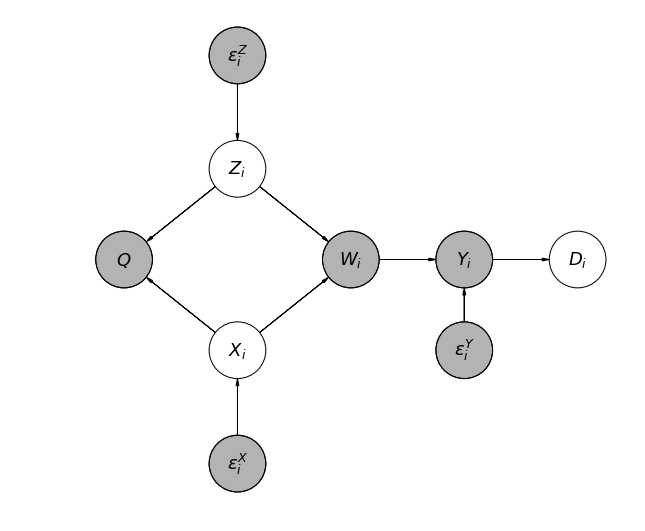

In [2]:
# declare the shape and size, and various styling
pgm = daft.PGM(shape=[5.5, 4.5], 
               origin=[-1, -1], 
               grid_unit=4,
               directed=True,
               label_params={'fontsize':18})

# Variable Nodes
pgm.add_node(daft.Node('Y', 
                       r'$Y_i$', 
                       3, 1.3,
                       observed=True,
                       scale=2))
pgm.add_node(daft.Node('W', 
                       r'$W_i$', 
                       2, 1.3,
                       observed=True,
                       scale=2))
pgm.add_node(daft.Node('X',
                       r'$X_i$', 
                       1, 0.5, 
                       scale=2))
pgm.add_node(daft.Node('Z',
                       r'$Z_i$',
                       1, 2.1, 
                       scale=2))
pgm.add_node(daft.Node('D',
                       r'$D_i$',
                       4, 1.3, 
                       scale=2))

# Propensity Node
pgm.add_node(daft.Node('Q', 
                       r'$Q$', 
                       0, 1.3,
                       observed=True,
                       scale=2))

# Disturbance nodes
pgm.add_node(daft.Node('eY', 
                       r'$\varepsilon^{Y}_i$', 
                       3, 0.5,
                       observed=True,
                       scale=2))

pgm.add_node(daft.Node('eX', 
                       r'$\varepsilon^{X}_i$', 
                       1, -0.5,
                       observed=True,
                       scale=2))

pgm.add_node(daft.Node('eZ', 
                       r'$\varepsilon^{Z}_i$', 
                       1, 3.1,
                       observed=True,
                       scale=2))
# Add directed edges
pgm.add_edge('eZ', 'Z')
pgm.add_edge('eX', 'X')
pgm.add_edge('eY', 'Y')
pgm.add_edge('X', 'W')
pgm.add_edge('Z', 'W')
pgm.add_edge('W', 'Y')
pgm.add_edge('Y','D')
pgm.add_edge('Z','Q')
pgm.add_edge('X','Q')

# Render and save.
pgm.render()
plt.show()

The diagram illustrates how:

- $Z_i$ and $X_i$ are independent in the population; and
- $Q_i$ is a sink.  Hence, conditioning on $Q_i = q_i$ induces a correlation among  $Z_i$ and $X_i$
- (Variables $Q_i$ and $W_i$ are grayed out to indicate they are typically unobserved.  This is because they depend on unkown population parameters $\boldsymbol\beta$.)

**Claim 2**: When selection into treatment is on observables (a.k.a strongly ignorable), and the true model and its parameters are known, conditioning on the _true_ propensity score is  sufficient to satisfy the backdoor criterion for identifying $P(y'_i \mid \text{do}(d_i))$, $y'_i$ an outcome of interest.    
_Proof_: By contradiction. By Claim 1 conditioning on $q_i$ is equivalent to conditioning on $w_i^{q_i}$. From the graph we can see that $W_i$ blocks all backdoor paths between the treatment $D_i$ and the outcome.  Suppose it did not.  Then there exists another observed covariate that is a parent of $W_i$ and an ancestor (or a descendant of an ancestor) of the outcome, but is not a parent of the _true_ propensity score, or the parameters of the propensity score are not the _true_ parameters $\rightarrow\leftarrow$.

### Problems with Propensity Score Matching (PSM)

To summarize, PSM tries to recreate a complete randomized experiment _stratified along Isopropenity Sets_ ($\mathcal{I}_{q_i}$).  Within each set $\mathcal{I}_{q_i}$, units are assigned to treatment with probability $q_i$.  This is enough to avoid selection bias within strata. In addition, by Claim 1, conditioning on $q_i$ is equivalent to conditioning on $w_i^{q_i}$, which, by Claim 2, is enough to d-separate the treatment from the outcome.  This too, avoids selection bias within strata. In effect, conditioning on the propensity score kills two birds with one stone, so what could go wrong?

Unfortunately, the problems with PSM concern estimation not identification. Specifically, complete randomization has two major shortcomings for the purposes of practical estimation:

1. Treatment groups will often be of unequal size, specially in strata where the propensity score is very close to 0 or 1.  This reduces the efficiency of the estimator, and the power of the design.
2. Chance imbalances are highly probable in thinly populated strata.  This is because covariates will typically vary widely within strata, and do so in a correlated fashion (as should be obvious from Definition 1b, and the fact that $Q_i$ is a collider).  Indeed, the maximum imbalance is potentially unbounded.

The first problem can be addressed by trimming the propensity score.  The second, by merging strata to reduce sparsity within strata. However, this involves trading off more asymptotic bias (by letting $w_i$ vary within the wider strata, and with it the influence of backdoor paths) for less conditional (on the sample) bias (by reducing sparsity and within strata imbalance).  For example, [Imbens and Rubin](https://doi.org/10.1017/CBO9781139025751) propose an algorithm that starts with one large strata, and then subdivides the strata until covariates are balanced across all strata. It remains to be seen whether their algorithm is optimal: Further strata partitioning may increase efficiency without worsening balance.  However, it suggest they are aware of the issues involved.

## Illustrative example

### Creating a simulated dataset
Here I use simulated data from the true model above to illustrate the problem.  First, I parameterize the model.  I do this by sampling parameters $\boldsymbol\beta, \boldsymbol\gamma, \boldsymbol\alpha$ from a uniform distribution on the closed range [-1,1]. Second, I generate 10,000,000 observations from the parameterized true model. The first ten rows of some variables from the simulated dataset are displayed below:

In [3]:
# Fixing random state for reproducibility
np.random.seed(92348)

# Generate a sample of data from the true causal model
df = sample_dgp2(15000000)
# print(df.describe(),'\n')
df.head(5)

,Y,X,Z,ey,D
0,-2.765757,-0.791310,1.606558,-2.350435,0
1,3.025277,-1.192201,1.141433,2.925136,1
2,10.490903,-0.800668,0.920998,10.393015,1
3,1.226213,-0.737515,0.797546,1.063397,1
4,4.903368,0.275413,0.156417,4.693756,1


Matching works by estimating the propensity score, and then stratifying on isopropensity sets.  I take these in turn.

### Estimating the propensity score

Estimates are shown below:

In [4]:
# Fit a logit using maximum likelihood

mod1 = smf.logit(formula='D ~ X + Z', data=df) # Define model
est1 = mod1.fit() # estimate model
print(est1.summary())

Optimization terminated successfully.
         Current function value: 0.690624
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      D   No. Observations:             15000000
Model:                          Logit   Df Residuals:                 14999997
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:                0.003638
Time:                        18:41:03   Log-Likelihood:            -1.0359e+07
converged:                       True   LL-Null:                   -1.0397e+07
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1318      0.001    119.906      0.000       0.130       0.134
X             -0.1288      0.

Next, I use the estimated equation to generate propensity score estimates ($\hat{Q}$).  The first 10 estimates are shown in the last column below:

In [5]:
df['Q_hat'] = est1.predict()  # prediction using training data
df.head(5)

,Y,X,Z,ey,D,Q_hat
0,-2.765757,-0.791310,1.606558,-2.350435,0,0.468942
1,3.025277,-1.192201,1.141433,2.925136,1,0.507734
2,10.490903,-0.800668,0.920998,10.393015,1,0.507411
3,1.226213,-0.737515,0.797546,1.063397,1,0.512255
4,4.903368,0.275413,0.156417,4.693756,1,0.515364


Now that we have estimated the propensity score for all observations, we are ready to approximate an isopropensity set.

### Approximating the isopropensity set 

To approximate an isopropensity set I subset the population data to include only those units with estimated propensity score $\hat{q}_i \in [0.6000,0.6010)$.  That is, I will considering units whose estimated scores are within less than 0.1 percent of each other. 

As shown in the table below, there are 3,200 units in the approximate isopropensity set $\mathcal{I}_{\hat{q}_i}$.

In [6]:
strata = df[(df['Q_hat']>=0.6000) & (df['Q_hat']< 0.6010)]
strata.describe()

,Y,X,Z,ey,D,Q_hat
count,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000,3200.000000
mean,1.423641,-1.600874,-0.311581,0.070922,0.608437,0.600490
std,5.853128,0.519037,0.299908,5.853161,0.488176,0.000289
min,-26.958070,-3.521202,-1.486972,-28.308008,0.000000,0.600000
25%,-2.285018,-1.942326,-0.513235,-3.643877,0.000000,0.600239
50%,1.562641,-1.588533,-0.319232,0.208789,1.000000,0.600489
75%,5.010182,-1.250288,-0.114594,3.659775,1.000000,0.600742
max,31.576768,0.421506,0.795437,30.215678,1.000000,0.601000


### Graphical Analysis

Consider the figure below.  The first panel displays a scatter plot of a random sample of 3,200 units from the population in covariate space $(X,Z)$.  Observations are colored by treatment status $D$.  Treated units are shown in red, and control units in blue. The second panels displays a scatter plot of the units in the isopropensity set $\mathcal{I}_{\hat{q}_i}$. The third panel display a hypothetical example of exact matching on approximate isopropensity sets $\mathcal{I}_{\hat{q}_1}$, and $\mathcal{I}_{\hat{q}_2}$.  All plots are on the same scale.

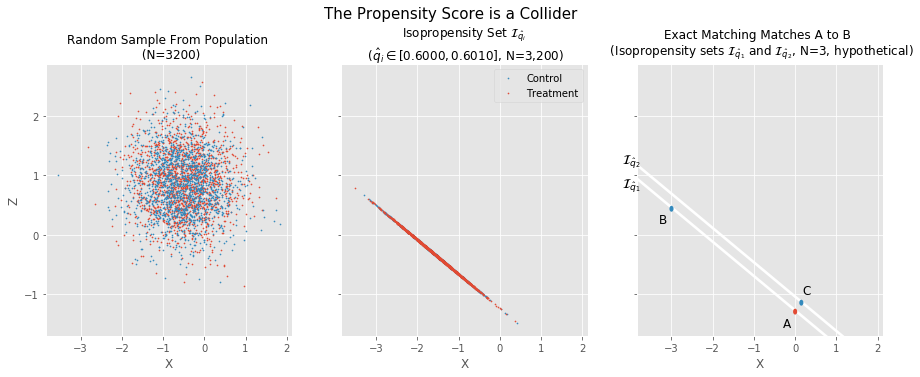

In [7]:
# Create random sample from population
random_sample = df.sample(n=strata.shape[0])

# Create figure
fig, (ax2, ax1, ax3) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5))

# Plot isopropensity score
ax1.scatter(strata[strata['D']==0].X, strata[strata['D']==0].Z, 
            c='C1',
            s=5,
            marker='.',
            label='Control')
ax1.scatter(strata[strata['D']==1].X, strata[strata['D']==1].Z, 
            c='C0',
            s=5,
            marker='.',
            label='Treatment')
ax1.legend()

# Plot random sample
ax2.scatter(random_sample[random_sample['D']==0].X, random_sample[random_sample['D']==0].Z, 
            c='C0',
            s=5,
            marker='.',
            label='Control')
ax2.scatter(random_sample[(random_sample.D==1)].X, random_sample[(random_sample.D==1)].Z, 
            c='C1',
            s=5,
            marker='.',
            label='Treatment')

# Draw rectangle patches
rectangle1 = plt.Rectangle((0.8, -1.76), 0.05, 5.5, angle=60.0, fill=True, fc='white')
ax3.add_patch(rectangle1)
rectangle2 = plt.Rectangle((1.2, -1.76), 0.05, 5.9, angle=60.0, fill=True, fc='white')
ax3.add_patch(rectangle2)

# Draw point patches and labels
point1 = plt.Circle((0, -1.29), 0.05, fc='C0')
ax3.add_patch(point1)
ax3.text(-0.3, -1.55, 'A', fontsize=12)
point2 = plt.Circle((-3, 0.44), 0.05, fc='C1')
ax3.add_patch(point2)
ax3.text(-3.3, 0.19, 'B', fontsize=12)
point3 = plt.Circle((0.15, -1.14), 0.05, fc='C1')
ax3.add_patch(point3)
ax3.text(0.17, -1.0, 'C', fontsize=12)

# Draw isopropensity set labels
ax3.text(-4.2, 0.8, r'$\mathcal{I}_{\hat{q}_1}$', fontsize=13)
ax3.text(-4.2, 1.2, r'$\mathcal{I}_{\hat{q}_2}$', fontsize=13)

# Titles and labels
fig.suptitle('The Propensity Score is a Collider', y=1.04, fontsize=15)
ax2.set_title('Random Sample From Population \n (N=3200)', fontsize=12)
ax1.set_title('Isopropensity Set $\mathcal{I}_{\hat{q}_i}$ \n ($\hat{q}_i \in [0.6000,0.6010]$, N=3,200)', fontsize=12)
ax3.set_title('Exact Matching Matches A to B \n (Isopropensity sets $\mathcal{I}_{\hat{q}_1}$ and $\mathcal{I}_{\hat{q}_2}$, N=3, hypothetical)', fontsize=12)
ax2.set_xlabel('X')
ax1.set_xlabel('X')
ax3.set_xlabel('X')
ax2.set_ylabel('Z')
fig.savefig("./img/fig_collider.jpg");
#plt.close(fig)



Covariates $X$ and $Z$ are independent in the population (left panel) but they are dependent conditional on the propensity score (middle panel).  This is because, as was shown in the causal diagram, the propensity score is a collider.  Covariates can also vary widely within isopropensity sets (middle and right panels).  Isopropensity sets can also be sparsely populated at extreme values of the covariates (middle panel).  Finally, exact matching may yield suboptimal matches in terms of covariate balance (right panel). 

Exact matching is asymptotically unbiased, but can be inefficient when isopropensity sets are sparsely populated. Hence, we might reduce conditional (on the sample) bias by widening the approximate isopropensity sets. For example, by defining an approximate set $\mathcal{I}_{\hat{q}_3}$ that encompases the polygon within $\mathcal{I}_{\hat{q}_1}$ and $\mathcal{I}_{\hat{q}_2}$ inclusive (i.e. by coarsening or, relatedly, by using a caliper).  In this case, exact matching would properly match A and C but at the price of asymptotic bias. Such tradeoffs are typical of regularized estimators, which trade asymptotic bias for better in sample performance.   

Also, in this specific example the sparsity happens at the extremes of the isopropensity set (middle panel) because these data are normally distributed.  To improve balance we might need to trim extreme values of the covariates within isopropensity sets or, more generally, from covariate spaces where the joint density is close to zero. (This trimming is in addition to trimming the propensity score where $q_i$ is close to 0 or 1, see above.) 

Finally, consider the figure below.  It displays the pairwise relations among the observed covariates and the unobserved "forcing variable" $(X, Z, e_y)$ by values of the binary treatment $D$. The first two panels in the bottom row show how $X$ and $Z$ are uncorrelated with the treatment $D$.  This is indeed an implication of Claims 1 and 2 above.  However, they also show a lack of overlap at more extreme values of the covariates.  The third panel in the bottom row shows how treatment assignment is completely determined by the value of $e_y$  within an isopropensity set. This follows directly from Claim 1 above.  The latter also implies that $e_y$ is uncorrelated with variables $Z$ and $X$ (second row).

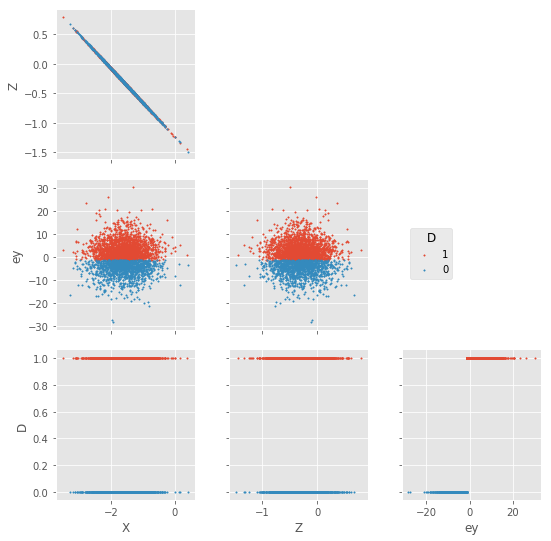

In [8]:
g = sns.PairGrid(strata[['X','Z','ey','D']], hue='D', hue_order = [1,0], size=2.5, hue_kws={"marker": [".", "."]})
g = g.map_lower(plt.scatter, s=8)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
g.axes[3,3].set_visible(False)
g.axes[0,0].set_visible(False)
g.axes[1,1].set_visible(False)
g.axes[2,2].set_visible(False)
g.axes[3,3].set_visible(False)
g = g.add_legend()
g.fig.get_children()[-1].set_bbox_to_anchor((0.6, 0.4, 0, 0))


### The Sparsity-Asymptotic Imbalance Tradeoff

- TODO: Graph showing relation between imbalance metrics and sparsity

## Conclusion

In this blog post I have provided a graphical reinterpretation of the claims made by King and Nielsen.  Specifically, I have shown how the propensity score is a collider, and that PSM tries to recreate a complete randomized experiment _stratified along Isopropenity Sets_ ($\mathcal{I}_{q_i}$).  This provides a structural, root cause explanation of the problems with PSM identified by King and Nielsen. 

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/80x15.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Beware the Propensity Score: It's a Collider</span> by <span xmlns:cc="http://creativecommons.org/ns#" property="cc:attributionName">Fernando Martel García</span> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.